## Assymmetric filter weights

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect, TimedInput
from connectivity_functions import create_orthogonal_canonical_representation, build_network_representation
from connectivity_functions import get_weights_from_probabilities, get_probabilities_from_network_representation
from connectivity_functions import create_matrix_from_sequences_representation, produce_overlaped_sequences
from analysis_functions import calculate_recall_time_quantities, get_weights
from analysis_functions import get_weights_collections
from plotting_functions import plot_network_activity_angle, plot_weight_matrix
from analysis_functions import calculate_angle_from_history, calculate_winning_pattern_from_distances
from analysis_functions import calculate_patterns_timings, calculate_recall_success_nr

epsilon = 10e-80

## An example

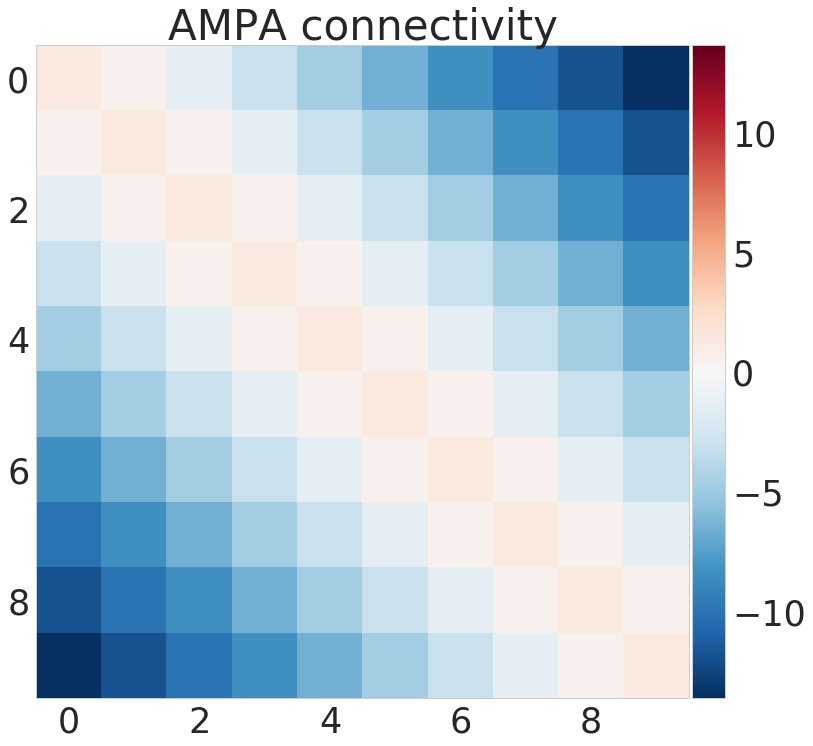

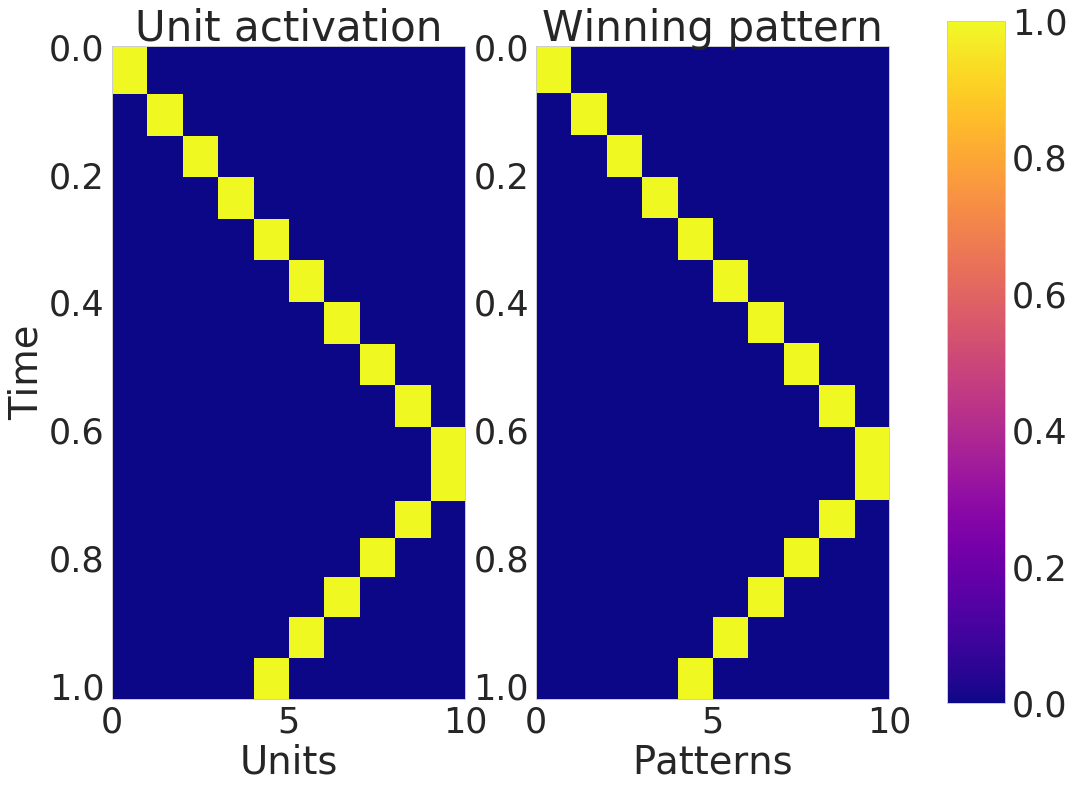

In [12]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
g_beta = 1.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 'i_ampa', 'a']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

# Recall
T_recall = 1.0
T_cue = 0.020

# Patterns parameters
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, 
                  g_beta=g_beta, sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, 
                  tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, z_transfer=z_transfer, 
                  diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)

nr = build_network_representation(matrix, minicolumns, hypercolumns)
timed_input = TimedInput(nr, dt, training_time, 
                         inter_pulse_interval=inter_pulse_interval, 
                         inter_sequence_interval=inter_sequence_interval, 
                         epochs=epochs, resting_time=resting_time)

S = timed_input.build_timed_input()
z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
w_total, beta = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)

nn.w_ampa = w_total
nn.beta = beta

# Dictionary
aux, indexes = np.unique(nr, axis=0, return_index=True)
patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
manager.patterns_dic = patterns_dic

plot_weight_matrix(manager.nn, ampa=True)

aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=0.010)
s1, timings, pattern_sequence = aux
plot_network_activity_angle(manager)

In [13]:
index_back = 2
index_from = 3
index_to = 4
w_self = w_total[index_from, index_from]
w_next = w_total[index_to, index_from]
w_rest = w_total[index_to + 1, index_from]
w_back = w_total[index_back, index_from]

## Extract the weights for a collection

In [79]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
g_beta = 1.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 'i_ampa', 'a']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

# Recall
T_recall = 1.0
T_cue = 0.020

num1 = 20
num2 = 20
tau_z_pre_vector = np.linspace(0.005, 0.150, num=num1)
tau_z_post_vector = np.linspace(0.005, 0.150, num=num2)
w_self_vector = np.zeros((num1, num2))
w_next_vector = np.zeros((num1, num2))
w_rest_vector = np.zeros((num1, num2))
w_back_vector = np.zeros((num1, num2))
successes_vector = np.zeros((num1, num2))
persistence_vector = np.zeros((num1, num2))


for index1, tau_z_pre_ampa in enumerate(tau_z_pre_vector):
    print(tau_z_pre_ampa)
    for index2, tau_z_post_ampa in enumerate(tau_z_post_vector):
            # Patterns parameters
            nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, 
                              g_beta=g_beta, sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, 
                              tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, z_transfer=z_transfer, 
                              diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                              perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                              normalized_currents=normalized_currents)

            # Build the manager
            manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

            # Build the protocol for training
            matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)

            nr = build_network_representation(matrix, minicolumns, hypercolumns)
            timed_input = TimedInput(nr, dt, training_time, 
                                     inter_pulse_interval=inter_pulse_interval, 
                                     inter_sequence_interval=inter_sequence_interval, 
                                     epochs=epochs, resting_time=resting_time)

            S = timed_input.build_timed_input()
            z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
            z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

            pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
            w_total, beta = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)

            nn.w_ampa = w_total
            nn.beta = beta

            # Dictionary
            aux, indexes = np.unique(nr, axis=0, return_index=True)
            patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
            manager.patterns_dic = patterns_dic
            
            w_self_vector[index1, index2] = w_total[index_from, index_from]
            w_next_vector[index1, index2] = w_total[index_to, index_from]
            w_rest_vector[index1, index2] = w_total[index_to + 1, index_from]
            w_back_vector[index1, index2] = w_total[index_back, index_from]

            aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=0.010)
            s, timings, pattern_sequence = aux
            times = [t[1] for t in timings[1:n_patterns - 1]]
            time = np.mean(times)
            successes_vector[index1, index2] = s
            persistence_vector[index1, index2] = time

0.005
0.0126315789474
0.0202631578947
0.0278947368421
0.0355263157895
0.0431578947368
0.0507894736842
0.0584210526316
0.0660526315789
0.0736842105263
0.0813157894737
0.0889473684211
0.0965789473684
0.104210526316
0.111842105263
0.119473684211
0.127105263158
0.134736842105
0.142368421053
0.15


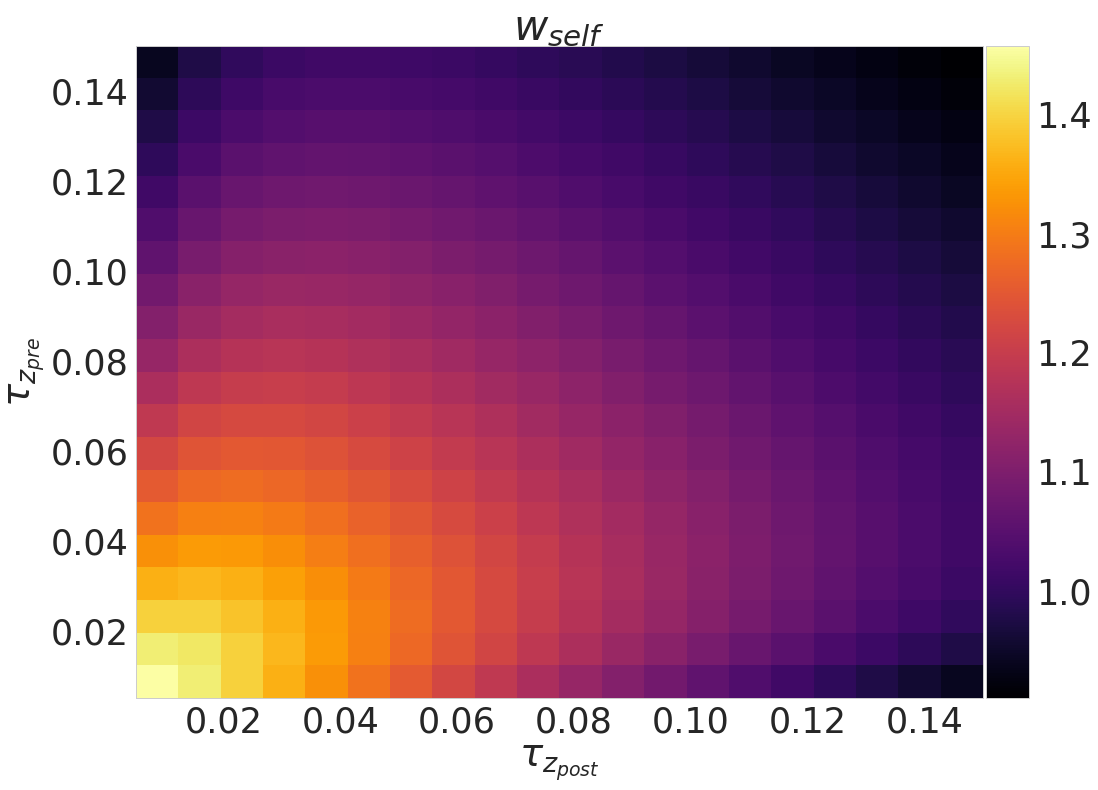

In [35]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
cmap = matplotlib.cm.inferno
extent = [tau_z_post_vector[0], tau_z_post_vector[-1], tau_z_pre_vector[0], tau_z_pre_vector[-1]]

im = ax.imshow(w_self_vector, cmap=cmap, extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel(r'$\tau_{z_{post}}$')
ax.set_ylabel(r'$\tau_{z_{pre}}$')
ax.set_title(r'$w_{self}$');

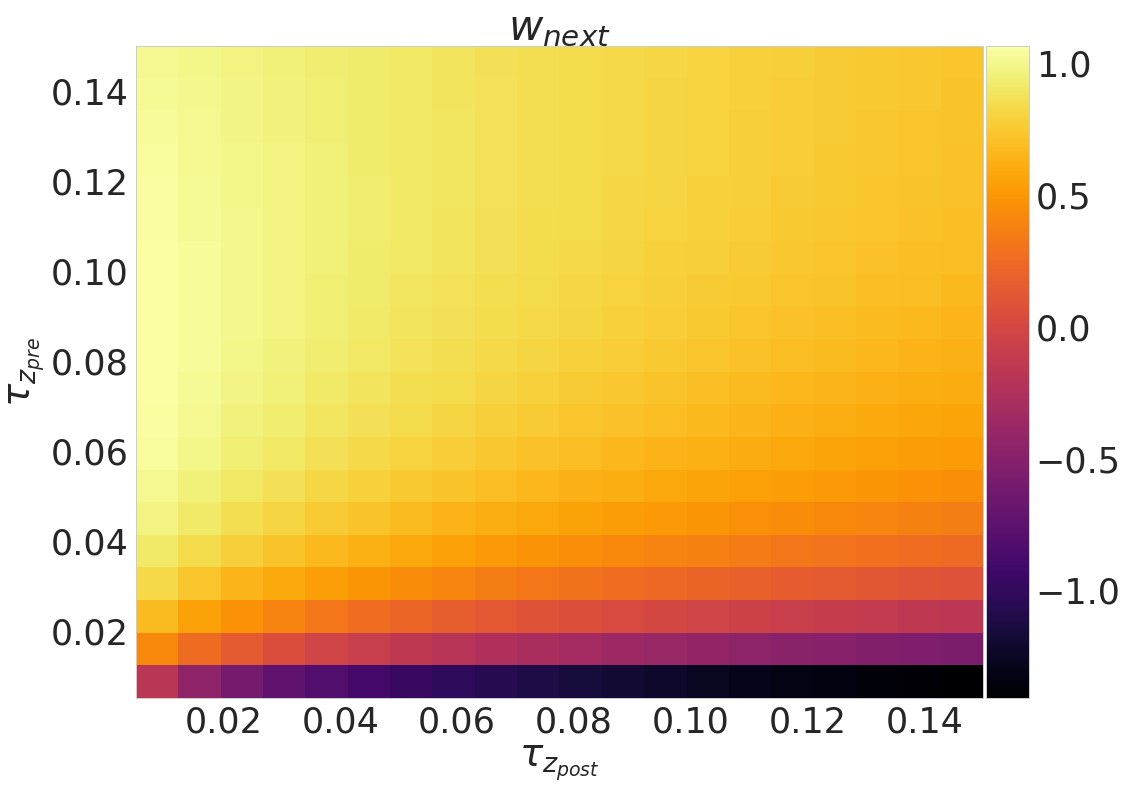

In [36]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
cmap = matplotlib.cm.inferno
extent = [tau_z_post_vector[0], tau_z_post_vector[-1], tau_z_pre_vector[0], tau_z_pre_vector[-1]]

im = ax.imshow(w_next_vector, cmap=cmap, extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel(r'$\tau_{z_{post}}$')
ax.set_ylabel(r'$\tau_{z_{pre}}$')
ax.set_title(r'$w_{next}$');

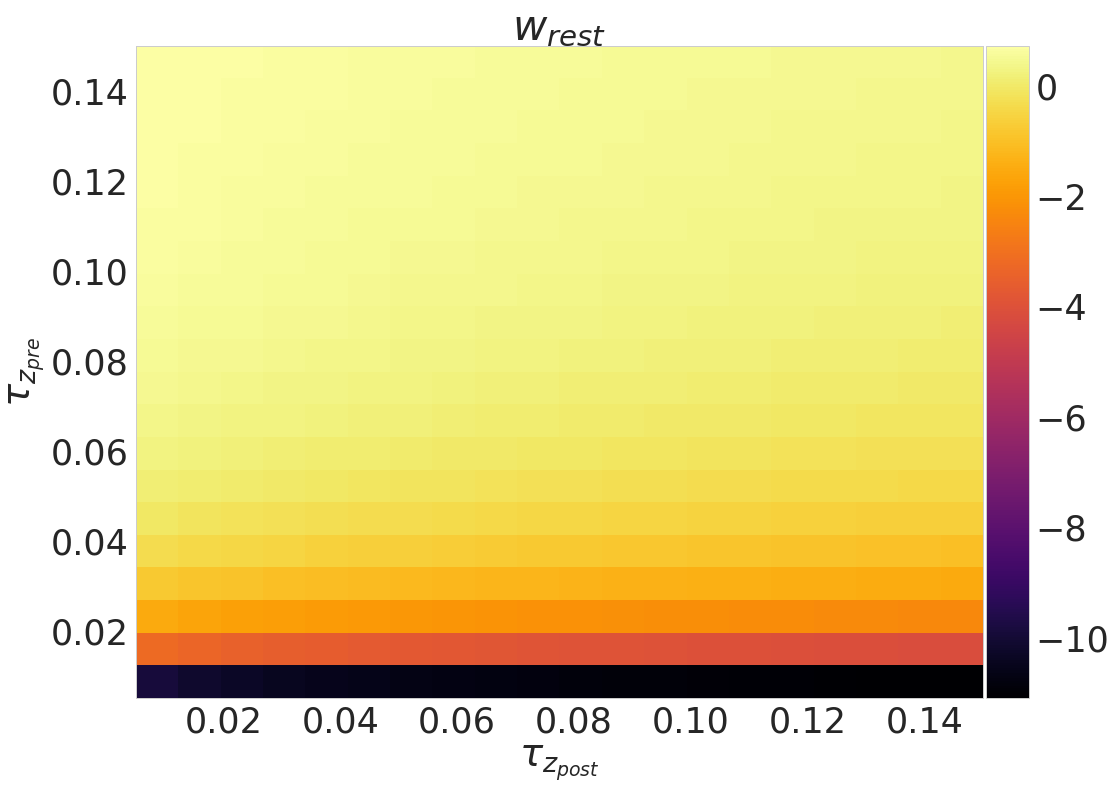

In [37]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
cmap = matplotlib.cm.inferno
extent = [tau_z_post_vector[0], tau_z_post_vector[-1], tau_z_pre_vector[0], tau_z_pre_vector[-1]]

im = ax.imshow(w_rest_vector, cmap=cmap, extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel(r'$\tau_{z_{post}}$')
ax.set_ylabel(r'$\tau_{z_{pre}}$')
ax.set_title(r'$w_{rest}$');

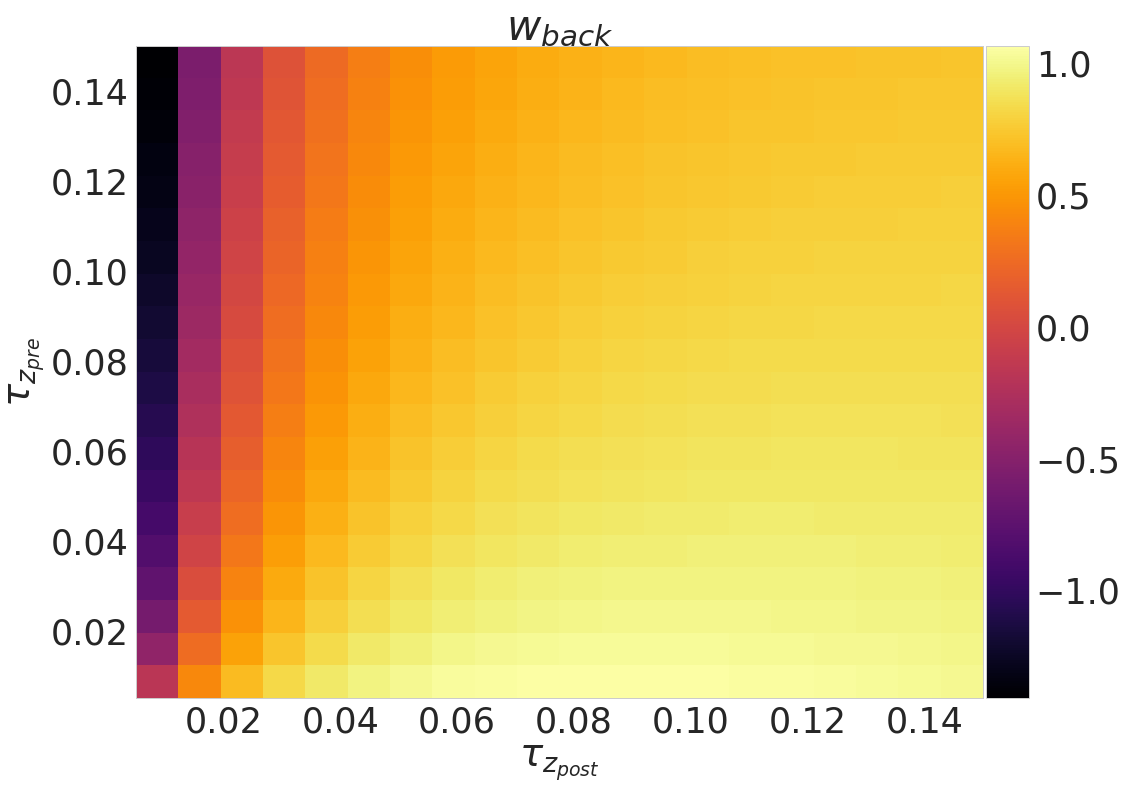

In [38]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
cmap = matplotlib.cm.inferno
extent = [tau_z_post_vector[0], tau_z_post_vector[-1], tau_z_pre_vector[0], tau_z_pre_vector[-1]]

im = ax.imshow(w_back_vector, cmap=cmap, extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel(r'$\tau_{z_{post}}$')
ax.set_ylabel(r'$\tau_{z_{pre}}$')
ax.set_title(r'$w_{back}$');

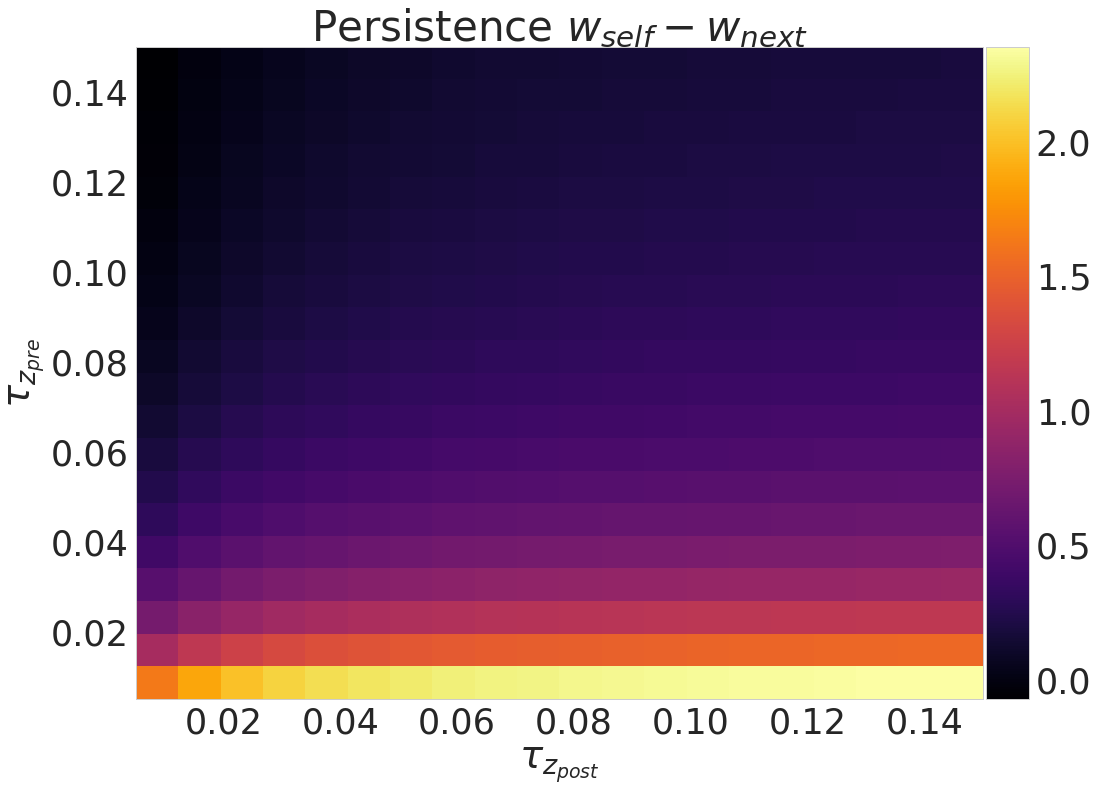

In [39]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
cmap = matplotlib.cm.inferno
extent = [tau_z_post_vector[0], tau_z_post_vector[-1], tau_z_pre_vector[0], tau_z_pre_vector[-1]]

im = ax.imshow(w_self_vector - w_next_vector, cmap=cmap, extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel(r'$\tau_{z_{post}}$')
ax.set_ylabel(r'$\tau_{z_{pre}}$')
ax.set_title(r'Persistence $w_{self} - w_{next}$');

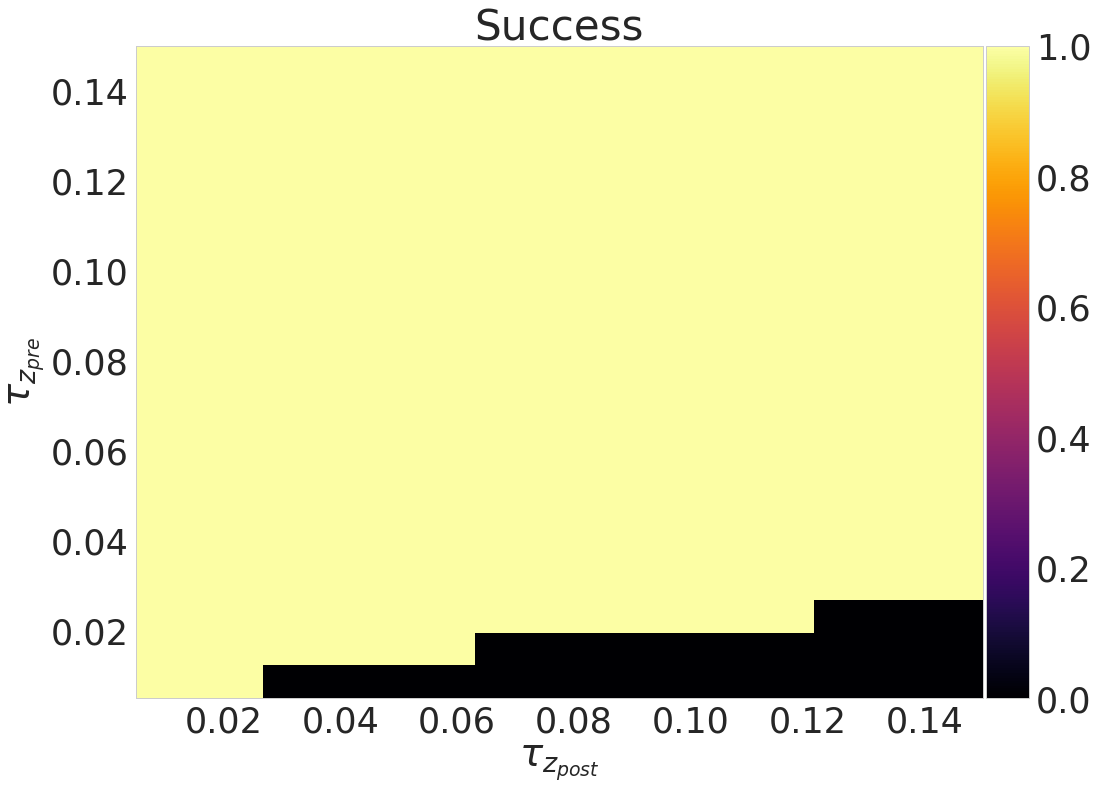

In [40]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
cmap = matplotlib.cm.inferno
extent = [tau_z_post_vector[0], tau_z_post_vector[-1], tau_z_pre_vector[0], tau_z_pre_vector[-1]]

im = ax.imshow(successes_vector, cmap=cmap, extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel(r'$\tau_{z_{post}}$')
ax.set_ylabel(r'$\tau_{z_{pre}}$')
ax.set_title(r'Success');

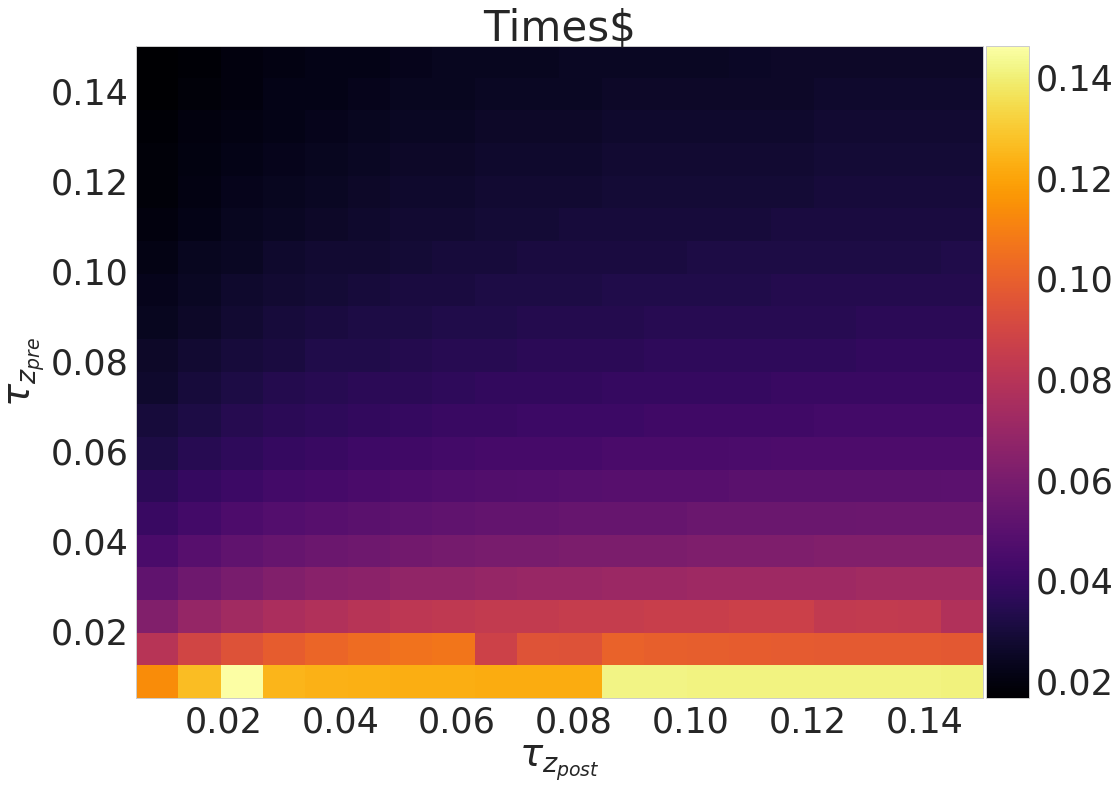

In [82]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
cmap = matplotlib.cm.inferno
extent = [tau_z_post_vector[0], tau_z_post_vector[-1], tau_z_pre_vector[0], tau_z_pre_vector[-1]]

im = ax.imshow(persistence_vector, cmap=cmap, extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel(r'$\tau_{z_{post}}$')
ax.set_ylabel(r'$\tau_{z_{pre}}$')
ax.set_title(r'Times');

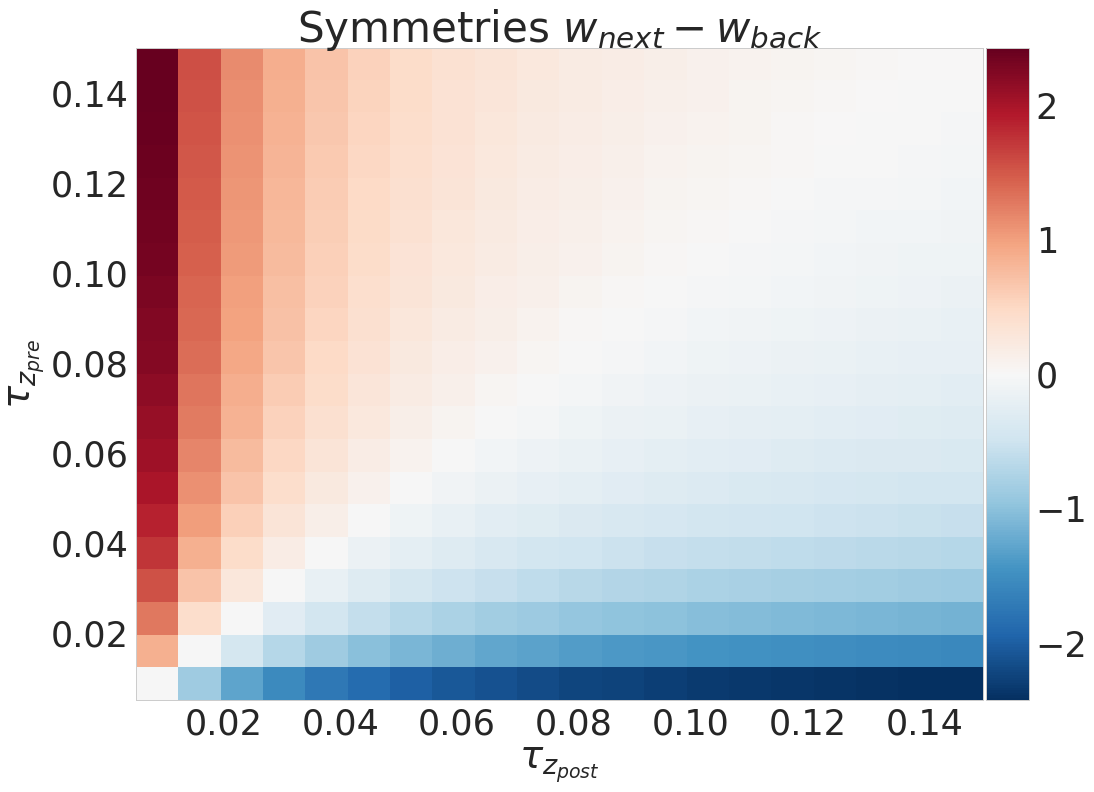

In [46]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
cmap = matplotlib.cm.RdBu_r
extent = [tau_z_post_vector[0], tau_z_post_vector[-1], tau_z_pre_vector[0], tau_z_pre_vector[-1]]

im = ax.imshow(w_next_vector - w_back_vector, cmap=cmap, extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel(r'$\tau_{z_{post}}$')
ax.set_ylabel(r'$\tau_{z_{pre}}$')
ax.set_title(r'Symmetries $w_{next} - w_{back}$');

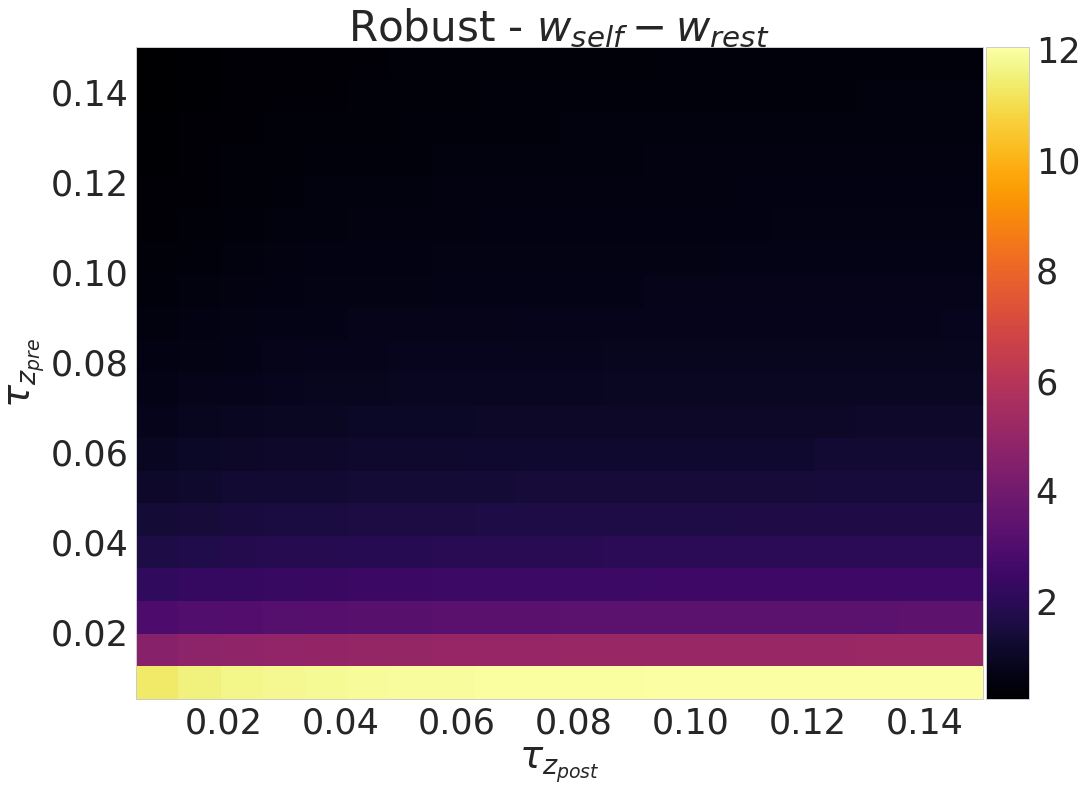

In [42]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
cmap = matplotlib.cm.inferno
extent = [tau_z_post_vector[0], tau_z_post_vector[-1], tau_z_pre_vector[0], tau_z_pre_vector[-1]]

im = ax.imshow(w_self_vector - w_rest_vector, cmap=cmap, extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel(r'$\tau_{z_{post}}$')
ax.set_ylabel(r'$\tau_{z_{pre}}$')
ax.set_title(r'Robust - $w_{self} - w_{rest}$');

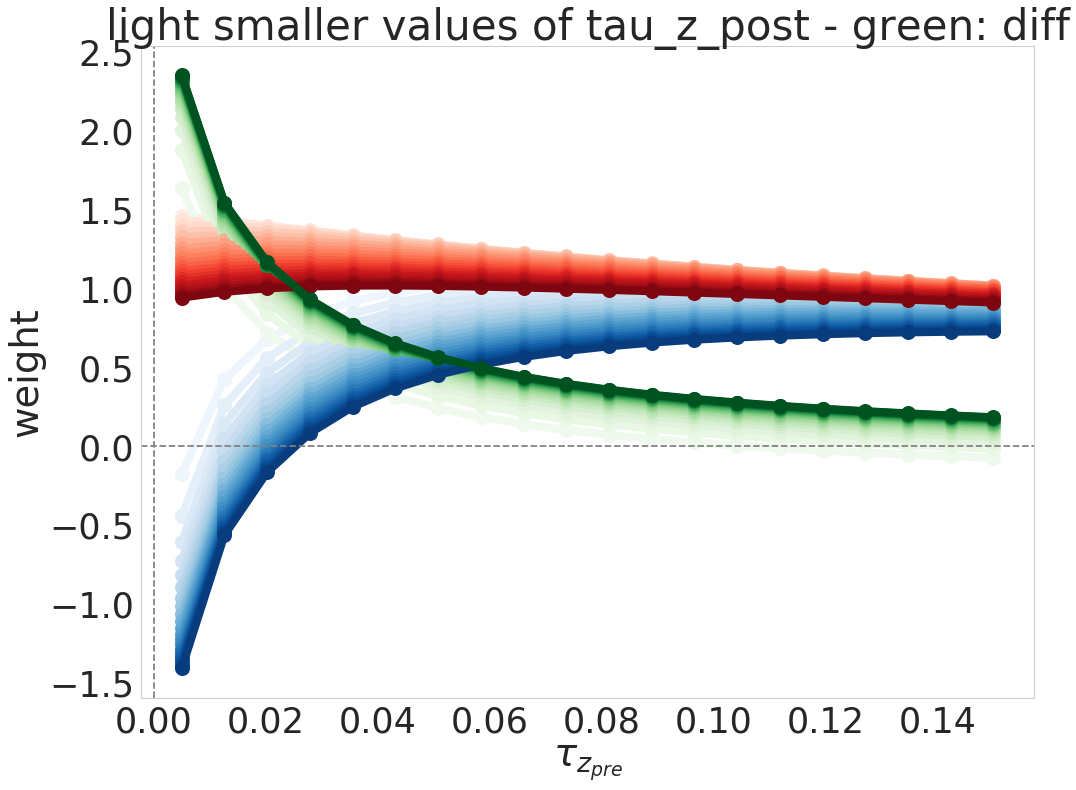

In [83]:
colors1 = sns.color_palette("Reds", num2)
colors2 = sns.color_palette("Blues", num2)
colors3 = sns.color_palette('Greens', num2)

lw = 8
ms = 15

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for index in range(num2):
    ax.plot(tau_z_pre_vector, w_self_vector[:, index], 'o-', ms=ms, lw=lw, color=colors1[index], 
            label='post' + str(tau_z_post_vector[index]) )
    ax.plot(tau_z_pre_vector, w_next_vector[:, index], 'o-', ms=ms, lw=lw, color=colors2[index], 
            label='post' + str(tau_z_post_vector[index]) )
    ax.plot(tau_z_pre_vector, w_self_vector[:, index] - w_next_vector[:, index], 'o-', ms=ms, lw=lw, color=colors3[index], 
            label='post' + str(tau_z_post_vector[index]) )

ax.set_title('light smaller values of tau_z_post - green: diff')
ax.set_xlabel(r'$\tau_{z_{pre}}$')
ax.set_ylabel('weight')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray');

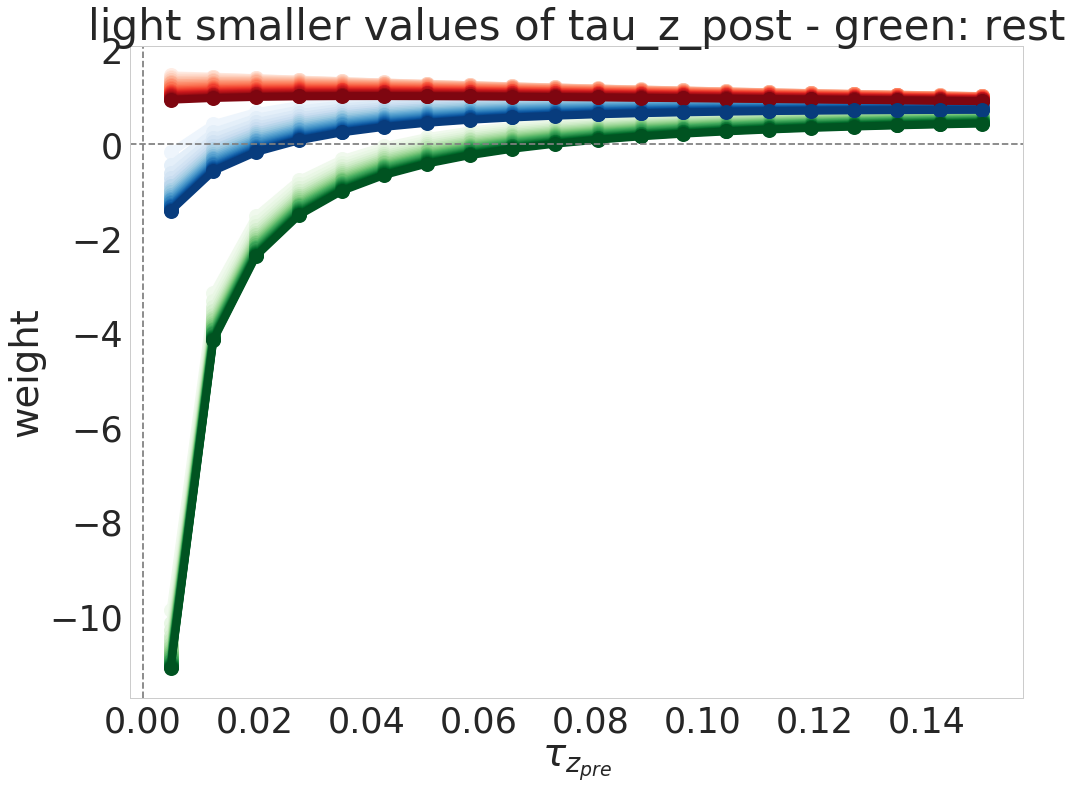

In [84]:
colors1 = sns.color_palette("Reds", num2)
colors2 = sns.color_palette("Blues", num2)
colors3 = sns.color_palette('Greens', num2)

lw = 8
ms = 15

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for index in range(num2):
    ax.plot(tau_z_pre_vector, w_self_vector[:, index], 'o-', ms=ms, lw=lw, color=colors1[index], 
            label='post' + str(tau_z_post_vector[index]) )
    ax.plot(tau_z_pre_vector, w_next_vector[:, index], 'o-', ms=ms, lw=lw, color=colors2[index], 
            label='post' + str(tau_z_post_vector[index]) )
    ax.plot(tau_z_pre_vector, w_rest_vector[:, index], 'o-', ms=ms, lw=lw, color=colors3[index], 
            label='post' + str(tau_z_post_vector[index]) )

ax.set_title('light smaller values of tau_z_post - green: rest')
ax.set_xlabel(r'$\tau_{z_{pre}}$')
ax.set_ylabel('weight')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray');

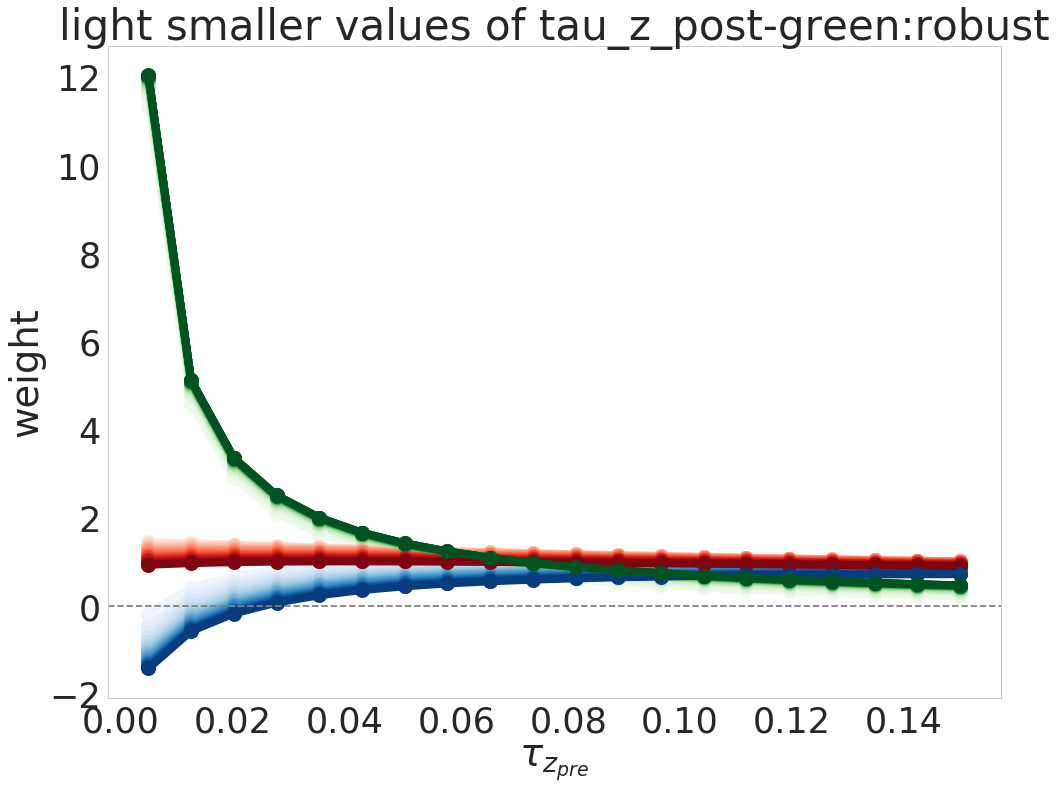

In [85]:
colors1 = sns.color_palette("Reds", num2)
colors2 = sns.color_palette("Blues", num2)
colors3 = sns.color_palette('Greens', num2)

lw = 8
ms = 15

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for index in range(num2):
    ax.plot(tau_z_pre_vector, w_self_vector[:, index], 'o-', ms=ms, lw=lw, color=colors1[index], 
            label='post' + str(tau_z_post_vector[index]) )
    ax.plot(tau_z_pre_vector, w_next_vector[:, index], 'o-', ms=ms, lw=lw, color=colors2[index], 
            label='post' + str(tau_z_post_vector[index]) )
    ax.plot(tau_z_pre_vector, w_self_vector[:, index] - w_rest_vector[:, index], 'o-', ms=ms, lw=lw, color=colors3[index], 
            label='post' + str(tau_z_post_vector[index]) )

ax.set_title('light smaller values of tau_z_post-green:robust')
ax.set_xlabel(r'$\tau_{z_{pre}}$')
ax.set_ylabel('weight')
ax.axhline(0, ls='--', color='gray')